# MSDS610 - Spark Inverted Index Project
Sam Fangman

### Files Included

1. `bigquery_stackoverflow_query.sql` 
    - Query used to gather the Stack Overflow data from BigQuery
2. `bq-results-20200301-stackoverflow.csv`
    - Results of BigQuery in csv form
3. `sf-spark-inverted-index.ipynb`
    - Jupyter notebook file used to create the inverted index from data with PySpark
4. `sf_inverted_index.json`
    - Initial output inverted index file.
5. `sf_inverted_index_formatted.json`
    - Final output of the inverted index file after re-formatting

### Problem Statement

*Query Stack Overflow’s data API to create and download a dataset. Next, use Spark, Jupyter notebook, and your cluster to create an inverted index listing all the Post IDs where each tag appears. To limit the query time and data transfer, please only use data from one year (e.g. 2017)*

### Solution

To solve the problem at hand, I first had to gather the relevant data. To gather this data, I queried the public stackoverlow [dataset](https://console.cloud.google.com/marketplace/details/stack-exchange/stack-overflow) in Google BigQuery. I crafted my query using standard SQL language, pulling from the `posts_questions` table (see below or `bigquery_stackoverflow_query.sql` for full query). 
```sql
SELECT
  id,
  post_type_id,
  creation_date,
  tags
FROM
  `bigquery-public-data.stackoverflow.posts_questions`
WHERE
  creation_date between '2018-01-01' and '2018-01-11'
ORDER BY
  creation_date asc;
```
To limit the number of rows returned, I narrowed the date range to a 10 day window in January, 2018. This query still returned nearly 49,000 rows of data. From this query, I discovered that the tags associated with each post were in a pipe-delimited format. I saved the query results in a csv (`bq-results-20200301-stackoverflow.csv`) for further processing using Spark.

After I had queried and gathered the dataset, I then set up a clustered environment using GCP Dataproc. This environment was configured to include HDFS (for distributed storage), Spark (for data processing on the distributed dataset), Anaconda (for the Python distribution), and Jupyter (to run interactive notebooks for Spark and Python). Once the infrastructure was properly configured, I loaded my query result csv onto the master node using a git [repository](https://github.com/sfangman/spark_inverted_index) and then passed the csv onto the HDFS storage using the `copyFromLocal` command.

I then used the following commands in Python and Spark (PySpark) to create an inverted index from the query results (See comments above each code block).

### Python (PySpark) Processing
Because I was using a PySpark Kernel, I did not need to import pyspark, I would use the code below if I was running a Python3 kernel

In [1]:
# import pyspark
# sc = pyspark.SparkContext(appName="WordCount")

Import relevant libraries for data processing & visualization

In [2]:
import pandas as pd
import json
from itertools import islice
from matplotlib import pyplot as plt

Check that the query results from stackoverflow were loaded in HDFS

In [3]:
!hdfs dfs -ls /stackoverflow

Found 2 items
-rw-r--r--   2 samuel_j_fangman hadoop    3221023 2020-03-02 17:15 /stackoverflow/bq-results-20200301-stackoverflow.csv
drwxr-xr-x   - root             hadoop          0 2020-03-02 17:17 /stackoverflow/sf_inverted_index


First I explored using a spark dataframe, but found using a traditional rdd would be easier

In [4]:
# df = spark.read.format('csv').option('header','true').load('/stackoverflow/bq-results-20200301-stackoverflow.csv')
# df.take(5)

Loaded the query results into hdfs through the terminal, loaded the file using the `sc.textFile` method

In [5]:
csv_file = sc.textFile('hdfs:///stackoverflow/bq-results-20200301-stackoverflow.csv')
csv_file.take(5)

['id,post_type_id,creation_date,tags',
 '48046378,1,2018-01-01 00:00:29.247 UTC,python|ctypes',
 '48046379,1,2018-01-01 00:00:32.377 UTC,python|django|nginx',
 '48046383,1,2018-01-01 00:01:14.33 UTC,karate',
 '48046384,1,2018-01-01 00:01:25.093 UTC,ios|swift|protocols']

Remove the header row using a function I found online (on stack overflow ironically enough)

In [6]:
csv_file_no_header = csv_file.mapPartitionsWithIndex(lambda idx, it: islice(it, 1, None) if idx == 0 else it)
csv_file_no_header.take(5)

['48046378,1,2018-01-01 00:00:29.247 UTC,python|ctypes',
 '48046379,1,2018-01-01 00:00:32.377 UTC,python|django|nginx',
 '48046383,1,2018-01-01 00:01:14.33 UTC,karate',
 '48046384,1,2018-01-01 00:01:25.093 UTC,ios|swift|protocols',
 '48046386,1,2018-01-01 00:02:28.78 UTC,javascript|angular']

Used a `map` function to grab the id and relevant tags of the post (tags had to be split further as they were pipe delimited)

In [7]:
id_taglist = csv_file_no_header.map(lambda x: (x.split(',')[0],x.split(',')[-1].split('|')))
id_taglist.take(5)

[('48046378', ['python', 'ctypes']),
 ('48046379', ['python', 'django', 'nginx']),
 ('48046383', ['karate']),
 ('48046384', ['ios', 'swift', 'protocols']),
 ('48046386', ['javascript', 'angular'])]

Used a `flatMap` function to flatten the id and tag lists in a reversed fashion, so my return was a list of tuples in the format `[(tag, id)],...`

In [8]:
tag_id_pair = id_taglist.flatMap(lambda idtags: [(tag, idtags[0]) for tag in idtags[1]])
tag_id_pair.take(5)

[('python', '48046378'),
 ('ctypes', '48046378'),
 ('python', '48046379'),
 ('django', '48046379'),
 ('nginx', '48046379')]

Used a `reduceByKey` function to reduce the list of tuples by key (tag), appending a comma and the next id to the value field of the `(tag, ids)` tuple

*Output is suppressed for brevity*

*This output had me scared I did something wrong, but it turns out there are just a million posts out there about python!)*

In [9]:
tag_idlist = tag_id_pair.reduceByKey(lambda a,b:a+','+b)
# tag_idlist.take(1)

Reformatted the data using a map function that converted the dataset to a list of dictionaries with the tag as the key and a list of ids as the values
```
[
    {
    "tag1":[id1,id2,...]
    },
    {
    "tag2":[id1,id2,...]
    },
    ...
]
```

In [10]:
inverted_index = tag_idlist.map(lambda x: {x[0]:[x[1]]})
# inverted_index.take(1)

Chained together my various functions used in this project to execute the data transformation in a single line

In [11]:
output = csv_file.mapPartitionsWithIndex(lambda idx, it: islice(it, 1, None) if idx == 0 else it)   \
            .map(lambda x: (x.split(',')[0],x.split(',')[-1].split('|')))   \
            .flatMap(lambda idtags: [(tag, idtags[0]) for tag in idtags[1]])   \
            .reduceByKey(lambda a,b:a+','+b)   \
            .map(lambda x: {x[0]:[x[1]]})
# output.take(5)

Saved output to HDFS 

In [31]:
output.saveAsTextFile('/stackoverflow/sf_inverted_index')

Confirmed that the data had been saved in HDFS

In [32]:
!hdfs dfs -ls /stackoverflow

Found 2 items
-rw-r--r--   2 samuel_j_fangman hadoop    3221023 2020-03-02 17:15 /stackoverflow/bq-results-20200301-stackoverflow.csv
drwxr-xr-x   - root             hadoop          0 2020-03-02 17:17 /stackoverflow/sf_inverted_index


Used the `-getmerge` command to merge and copy the output in HDFS to the master node

In [27]:
!hdfs dfs -getmerge /stackoverflow/sf_inverted_index /home/samuel_j_fangman/spark_inverted_index/sf_inverted_index.json

Confirmed the file was moved to the correct directory

In [15]:
!ls /home/samuel_j_fangman/spark_inverted_index

README.md			  bq-results-20200301-stackoverflow.csv
bigquery_stackoverflow_query.sql  sf_inverted_index.json


Loaded the RDD to a Spark DF for data visualization (had to use the pre-formatted RDD to get all of the data to go to Pandas)

In [43]:
spark_df = tag_idlist.toDF()
# spark_df.head()

Loaded the data into a Pandas DF for ease of visualization 

Applied some basic transformation to give a count of posts associated with each tag

In [44]:
df = spark_df.toPandas()
df.columns = ['post_tag', 'post_ids']
df['post_count'] = df['post_ids'].apply(lambda x: len(x))
df = df.sort_values(by='post_count', ascending=False).reset_index(drop=True)
df.head()

post_tag                                           post_ids  post_count
0  javascript  48046386,48046404,48046415,48046482,48046506,4...       51560
1      python  48046378,48046379,48046391,48046421,48046431,4...       43136
2        java  48046418,48046448,48046484,48046501,48046524,4...       32894
3     android  48046603,48046694,48046721,48046776,48046858,4...       29069
4         php  48046493,48046573,48046620,48046636,48046714,4...       26927

Used PyPlot to plot the top 10 tags used in the Jan 1 - Jan 10, 2018 timeline

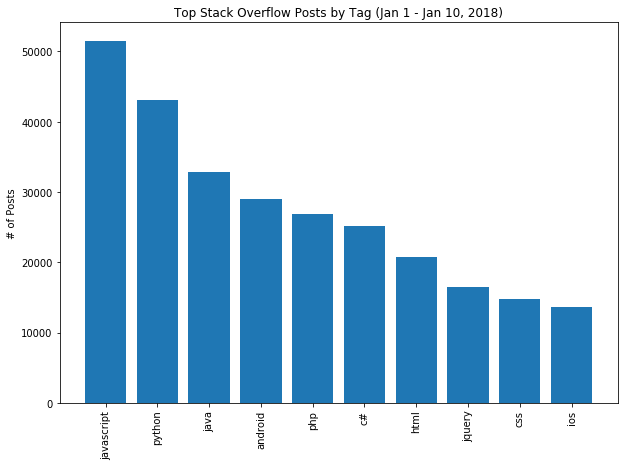

In [45]:
fig, ax = plt.subplots(figsize=(10,7))
plt.bar(df['post_tag'][0:10], df['post_count'][0:10])
plt.title('Top Stack Overflow Posts by Tag (Jan 1 - Jan 10, 2018)')
plt.ylabel('# of Posts')
plt.xticks(rotation=90)
plt.show()

After further review, I discovered that my json formatting was off using the `rdd.saveAsTextFile` method. 

As a result, I found another way to save my output by converting my RDD object to a json object using a `map` function with `json.dumps` as an argument and reducing the object to a single string

In [23]:
out_json = output.map(json.dumps)   \
            .reduce(lambda x,y:x+',\n'+y)

Finally, I wrote the json string to a file in my master node

In [24]:
with open('/home/samuel_j_fangman/spark_inverted_index/sf_inverted_index_formatted.json','w') as f:
    f.write(out_json)

Verified that the file was created in the correct directory

In [22]:
!ls /home/samuel_j_fangman/spark_inverted_index

README.md			       sf-spark-inverted-index.ipynb
bigquery_stackoverflow_query.sql       sf_inverted_index.json
bq-results-20200301-stackoverflow.csv  sf_inverted_index_formatted.json


The result of this analysis was the `sf_inverted_index_formatted.json` file which contains the formatted inverted index.

### Reflections and Lessons Learned

For me, this project displayed the power of both cloud computing and distributed computing. The suite of tools offered by GCP made the infrastructure associated with this project an afterthought. The Dataproc instance used to create the HDFS/Spark cluster only took around a minute to spin up and then was ready to go, with web interfaces pre-configured for Jupyter Lab. This type of setup would be ideal for smaller organizations that do not have the capital available to invest in on-premise resources. Further, it was interesting to work with the public datasets in BigQuery. They have a good number of interesting data sources available that only need a quick SQL query to get results. 

This project also displayed the power of Spark for processing large datasets. The dataset used in this example was not massive (~50,000 rows), but still was at a size where traditional processing using loops would be far more time consuming. By loading the data into distributed memory (RDDs), each command executed on the dataset took only a few seconds tops. It was also interesting to work with PySpark as a functional programming language where commands can be chained together in a single call. This seems like it would be a super useful function when scripting with PySpark. Moving forward, I would be interested to see how Spark would perform on truly large datasets in the range of GB-TB in volume.  